In [ ]:
# -*- coding: utf-8 -*-
"""
@author: Rukang Xu
"""

# Data Exploration of LIVECell

In [12]:
import os, inspect
import pathlib2
import pandas as pd
import numpy as np
import json
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import re

In [2]:
# Define the macro

MEDIUM_SIZE_THRESHOLD = 320
LARGE_SIZE_THRESHOLD = 970

In [2]:
# Helper functions

def learn_metadata(metadata_path):
    """
    learn about the basics of the metadata
    :param metadata_path: pathlib2.WindowsPath path representing the metadata file
    :return: dict metadata
    """

    # read the json file metadata as a dict
    with open(metadata_path) as json_data:
        metadata = json.load(json_data)

    # learn basic knowledge of metadata
    print(metadata.keys(), '\n\n')
    print('the type of images container: ', type(metadata['images']))
    print('the first element of <list> images: \n', metadata['images'][0], '\n\n')
    print('the type of annotations container: ', type(metadata['annotations']))
    print('the first ten keys of <dict> annotations: \n', list(metadata['annotations'].keys())[:10])
    print(f"the first item of <dict> annotations has the key: \n {list(metadata['annotations'].items())[0][0]} \nand the "
          f"value: \n{list(metadata['annotations'].items())[0][1]} \n\n")
    print('the type of categories container: ', type(metadata['categories']))
    print('the only element of <list> categories: \n', metadata['categories'][0], '\n\n')
    print('the type of info container: ', type(metadata['info']))
    print('the keys of <dict> info: \n', metadata['info'].keys(), '\n\n')
    print('the type of licenses container: ', type(metadata['licenses']))
    print('the first element of <list> licenses: \n', metadata['licenses'][0])

    return metadata

def check_noneffective_ids(df):
    """
    check if the given data frame has NaN and return the rows with it if any, or else return nothing
    :param df: pd.DataFrame input dataframe
    :return: pd.DataFrame dataframe including only non-valid rows if any
    """

    is_NaN = df.isnull()
    row_has_NaN = is_NaN.any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    len_rows_with_NaN = rows_with_NaN.shape[0]
    if len_rows_with_NaN != 0:
        print(f"there are {len_rows_with_NaN} non effective rows.")
        return rows_with_NaN
    else:
        print("the rows available are all effective, i.e., without NaNs.")
        return None

def check_meta_images_df(df_img):
    """
    check the validity of metadata of images
    :param df_img: pd.DataFrame dataframe that contains image metadata
    :return: int length of all items in df_img and
             int length of unique image ids and
             pd.DataFrame duplicated dataframe in terms of file_name if any
    """

    # check the number of available items and unique ids of the dataframe
    len_df_img = df_img.shape[0]
    print(f"there are {len_df_img} items in the image metadata frame.")
    img_ids_array = df_img['id'].unique()
    len_img_ids_array = img_ids_array.shape[0]
    print(f"there are {len_img_ids_array} unique ids (not images) in the image metadata frame.")

    # check if the ids are sorted by size
    img_ids_array_copy = img_ids_array.copy()
    img_ids_array_copy.sort()
    print(np.allclose(img_ids_array, img_ids_array_copy), ': the ids are sorted by size.')

    # check if all images are of the same size given the width and height
    uniq_width_arr = df_img['width'].unique()
    uniq_height_arr = df_img['height'].unique()
    if (uniq_width_arr.size == 1) and (uniq_height_arr.size == 1):
        print((uniq_width_arr[0] == 704) and (uniq_height_arr[0] == 520), ': all the images are of size (704, 520).')
    elif (uniq_width_arr.size != 1) and (uniq_height_arr.size == 1):
        print("some images have different width.")
    elif (uniq_width_arr.size == 1) and (uniq_height_arr.size != 1):
        print("some images have different height.")
    elif (uniq_width_arr.size != 1) and (uniq_height_arr.size != 1):
        print("some images have different size.")

    # check if all the file names have the same extension .tff
    # and check if all the file names are unique
    counts_of_tif_files = df_img['file_name'].str.count('.tif').sum()
    if counts_of_tif_files == len_df_img:
        print('all files are extended by .tff.')
    else:
        print('there are files extended by different file format.')

    uniq_file_names_arr = df_img['file_name'].unique()
    len_uniq_file_names_arr = uniq_file_names_arr.shape[0]
    print(f"there are {len_uniq_file_names_arr} unique file names in the image metadata frame.")
    if len_uniq_file_names_arr < len_df_img:
        has_duplicate = df_img['file_name'].duplicated()
        non_duplicates_filename = df_img[~has_duplicate]
        has_duplicate_all = df_img['file_name'].duplicated(keep=False)
        duplicates_filename_all = df_img[has_duplicate_all][["id", "file_name"]]
        duplicates_filename_all.reset_index(drop=True, inplace=True)
        return len_df_img, len_img_ids_array, non_duplicates_filename, duplicates_filename_all
    else:
        return len_df_img, len_img_ids_array

def check_filename_correspondence(series, image_path):
    """
    check the correspondence between the file_name column and the image file names in the corresponding directory
    :param series: pd.Series series representing file_name column extracted from the metadata of the image
    :param image_path: pathlib2.WindowsPath path representing the directory including all the images
    :return:
    """

    # check the number of valid images in the image_path
    valid_image_names_list = list()
    for cell_type_image_path in image_path.iterdir():
        for cell_image_path in cell_type_image_path.glob('*.tif'):
            if cell_image_path.stat().st_size is not None:
                valid_image_names_list.append(cell_image_path.name)
    print(f"the number of valid images in dir {image_path.name} is: {len(valid_image_names_list)}.")

    # check the correspondence between file_name column and valid images in the image_path
    valid_image_names_arr = np.asarray(valid_image_names_list)
    file_names_arr = series.to_numpy()
    print(f"the number of unique filenames in column file_name is: {file_names_arr.shape[0]}.")
    intersect_arr = np.intersect1d(file_names_arr, valid_image_names_arr)
    if intersect_arr.shape[0] == file_names_arr.shape[0]:
        print("all unique filenames in column file_name have the corresponding images.")
    else:
        print("there are missing images for the given unique filenames in column file_name.")

    return None

def check_meta_annots_df(df_img, df_annot):
    """
    check the validity of metadata of annotations
    :param df_img: pd.DataFrame dataframe that contains image metadata
    :param df_annot: pd.DataFrame dataframe that contains annotation metadata
    :return:
    """

    # check the equality between the index and column 'id' of the input dataframe
    index_arr = df_annot.index.to_numpy()
    index_arr = index_arr.astype('int64')
    ids_annot_arr = df_annot['id'].to_numpy()
    print(np.allclose(index_arr, ids_annot_arr), ': The index values and values of the id column of annotations metadata '
                                                 'in form of data frame is elementwise equal.')

    # check the number of unique values of some existing columns
    print(f"there are {ids_annot_arr.shape[0]} unique ids in the metadata for annotations.")
    img_ids_annot_arr = df_annot['image_id'].unique()
    print(f"there are {img_ids_annot_arr.shape[0]} unique image ids in the metadata for annotations.")
    category_ids_annot_arr = df_annot['category_id'].unique()
    print(f"there are {category_ids_annot_arr.shape[0]} unique categories in the metadata for annotations.")
    iscrowd_annot_arr = df_annot['iscrowd'].unique()
    print(f"there are {iscrowd_annot_arr.shape[0]} unique values of iscrowd in the metadata for annotations.")

    # check the pair relationship between image ids of metadata for images and annotations
    img_ids_img_arr = df_img['id'].to_numpy()  # already known that the id col is sorted by size
    print(np.allclose(img_ids_img_arr, np.sort(img_ids_annot_arr)), ': all the image ids of metadata for images and '
                                                                    'annotations are paired with each other.')

    # check the validity of segmentation column, according to the rule that at least three points form a closed polygon
    # !without checking the pixel values of each segmentation annotation
    cal_len_of_nested_list = lambda x: len(x[0])
    v_cal_len_of_nested_list = np.vectorize(cal_len_of_nested_list)
    seg_arr = df_annot['segmentation'].to_numpy()
    seg_len_arr = v_cal_len_of_nested_list(seg_arr)
    seg_valid_no = np.sum(np.where(seg_len_arr > 5, 1, 0))
    print(seg_valid_no == ids_annot_arr.shape[0], ': all the segmentation labels are valid.')

    # check the validity of area column, i.e., if all areas are greater than 0
    area_arr = df_annot['area'].to_numpy()
    area_valid_no = np.sum(np.where(area_arr > 0., 1, 0))
    print(area_valid_no == ids_annot_arr.shape[0], ': all the area labels are valid.')

    # check the validity of bbox column
    # !without checking the pixel values of each bbox annotation and its width and height
    cal_len_of_list = lambda x: len(x)
    v_cal_len_of_list = np.vectorize(cal_len_of_list)
    bbox_arr = df_annot['bbox'].to_numpy()
    bbox_len_arr = v_cal_len_of_list(bbox_arr)
    bbox_valid_no = np.sum(np.where(bbox_len_arr == 4, 1, 0))
    print(bbox_valid_no == ids_annot_arr.shape[0], ': all the bbox labels are valid.')

    return None

def check_duplicates_of_meta_annot(df_duplicates, df_annot, verbose=False):
    """
    check if the segmentation, area and bbox of the images ids, which refer to the same file names, are duplicated.
    :param df_duplicates: pd.DataFrame dataframe that contains duplicates information
    :param df_annot: pd.DataFrame dataframe that contains annotation metadata
    :param verbose: boolean flag denoting whether additional information should be displayed during operation
    :return:
    """

    if verbose:
        print(f"the length of given duplicated dataframe is: {df_duplicates.shape[0]}\n")
    df_duplicates_copy = df_duplicates.reset_index(drop=True)
    duplicates_id_lst = df_duplicates_copy['id'].to_list()
    df_annot_duplicates = df_annot[df_annot['image_id'].isin(duplicates_id_lst)][['image_id', 'segmentation',
                                                                                  'area', 'bbox']]
    if verbose:
        print(f"the length of resulting duplicated dataframe for annotations is: {df_annot_duplicates.shape[0]}")
        print(f"the length of resulting duplicated dataframe for annotations with only unique image_id is: "
              f"{df_annot_duplicates['image_id'].unique().shape[0]}\n")
    #seg_dup_arr, area_dup_arr, bbox_dup_arr = np.empty((3, len(duplicates_id_lst))) #ndarray seems to restrict the dtype
    seg_dup_lst = list()
    area_dup_lst = list()
    bbox_dup_lst = list()
    for i, img_id in enumerate(duplicates_id_lst):
        temp_seg_arr, temp_area_arr, temp_bbox_arr = \
            df_annot_duplicates[df_annot_duplicates['image_id']==img_id][['segmentation','area', 'bbox']].to_numpy().T
        #seg_dup_arr[i] = temp_seg_arr
        #area_dup_arr[i] = temp_area_arr
        #bbox_dup_arr[i] = temp_bbox_arr
        seg_dup_lst.append(temp_seg_arr)
        area_dup_lst.append(temp_area_arr)
        bbox_dup_lst.append(temp_bbox_arr)
    df_duplicates_copy.loc[:, 'segmentation'] = seg_dup_lst
    df_duplicates_copy.loc[:, 'area'] = area_dup_lst
    df_duplicates_copy.loc[:, 'bbox'] = bbox_dup_lst

    def to_string(x):
        # convert the x to string if x is an numpy array
        return str(sorted(x)) if isinstance(x, (list, np.ndarray)) else sorted(x)
    count_the_same_areas = 0
    count_some_diff_areas = 0
    count_all_diff_areas = 0
    unique_file_name_lst = df_duplicates['file_name'].unique().tolist()
    for file_name_element in unique_file_name_lst:
        temp_df = df_duplicates_copy[df_duplicates_copy['file_name'] == file_name_element]
        temp_df_len = temp_df.shape[0]
        # since the segmentation labels are themselves complicated and are related with area labels, if the area
        # labels are different, then the segmentation ones are also different. Thus, we can only focus on the inspection
        # of repeatability of area labels.

        if temp_df['area'].apply(to_string).nunique() == 1:
            if verbose:
                print(f"the area annotations for the image ids - {temp_df['id']} are the same.\n")
            count_the_same_areas += 1
        elif (temp_df['area'].apply(to_string).nunique() > 1) and (temp_df['area'].apply(to_string).nunique() < temp_df_len):
            if verbose:
                print(f"some of the area annotations for the image ids - {temp_df['id']} are the same.\n")
            count_some_diff_areas += 1
        elif temp_df['area'].apply(to_string).nunique() == temp_df_len:
            if verbose:
                print(f"none of the area annotations for the image ids - {temp_df['id']} is the same.\n")
            count_all_diff_areas += 1

    if count_the_same_areas == len(unique_file_name_lst):
        print('the area annotations for all the duplicate image ids in terms of file_name are the same.')
    elif count_some_diff_areas > 0:
        print('the area annotations for some duplicate image ids in terms of file_name are the same.')
    elif count_all_diff_areas == len(unique_file_name_lst):
        print('the area annotations for all the duplicate image ids in terms of file_name are different.')

    return df_duplicates_copy

## Define relevant paths

In [3]:
current_dir = pathlib2.Path.cwd()
# current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
print("currentdir: ", current_dir.as_posix())
project_dir = current_dir.parent
print("project dir: ", project_dir.as_posix())

currentdir:  F:/Kaggle/sartorius_cell_instance_segmentation/code/rkx_cell_is/analytics
project dir:  F:/Kaggle/sartorius_cell_instance_segmentation/code/rkx_cell_is


In [4]:
ds_path = project_dir / 'dataset'
print("dataset dir: ", ds_path.as_posix())
livecell_ds_path = ds_path / 'LIVECell_dataset_2021'
print("livecell dataset dir: ", livecell_ds_path.as_posix())
livecell_ds_annot_path, livecell_ds_imgs_path = [x for x in livecell_ds_path.iterdir() if x.is_dir()]

livecell_train_meta_path = livecell_ds_annot_path / 'LIVECell' / 'livecell_coco_train.json'
livecell_val_meta_path = livecell_ds_annot_path / 'LIVECell' / 'livecell_coco_val.json'
livecell_test_meta_path = livecell_ds_annot_path / 'LIVECell' / 'livecell_coco_test.json'

livecell_train_val_img_path = livecell_ds_imgs_path / 'livecell_train_val_images'
livecell_test_img_path = livecell_ds_imgs_path / 'livecell_test_images'

dataset dir:  F:/Kaggle/sartorius_cell_instance_segmentation/code/rkx_cell_is/dataset
livecell dataset dir:  F:/Kaggle/sartorius_cell_instance_segmentation/code/rkx_cell_is/dataset/LIVECell_dataset_2021


## Training metadata exploration

In [5]:
train_data = learn_metadata(livecell_train_meta_path)

dict_keys(['images', 'annotations', 'categories', 'info', 'licenses']) 


the type of images container:  <class 'list'>
the first element of <list> images: 
 {'id': 1, 'width': 704, 'height': 520, 'file_name': 'BT474_Phase_A3_2_00d04h00m_3.tif', 'original_filename': 'BT474_Phase_A3_2_00d04h00m_3.png', 'url': 'https://darwin.v7labs.com/api/images/870028/original'} 


the type of annotations container:  <class 'dict'>
the first ten keys of <dict> annotations: 
 ['2', '3', '4', '5', '6', '7', '8', '9', '10', '12']
the first item of <dict> annotations has the key: 
 2 
and the value: 
{'id': 2, 'image_id': 1, 'category_id': 1, 'segmentation': [[288.02, 305.63, 286.01, 298.87, 286.01, 295.4, 288.02, 290.1, 293.86, 287.91, 297.51, 287.73, 300.44, 289.01, 304.27, 292.48, 304.64, 295.04, 305.18, 297.77, 305.18, 300.7, 303.91, 302.52, 301.17, 305.26, 297.33, 307.45, 294.59, 307.45, 290.58, 308.0]], 'area': 307.4786000000313, 'bbox': [286.01, 287.73, 19.170000000000016, 20.269999999999982], 'isc

### Metadata: images

In [6]:
df_livecell_train_imgs_meta = pd.DataFrame.from_dict(train_data['images'])
df_livecell_train_imgs_meta.head()

,id,width,height,file_name,original_filename,url
0,1,704,520,BT474_Phase_A3_2_00d04h00m_3.tif,BT474_Phase_A3_2_00d04h00m_3.png,https://darwin.v7labs.com/api/images/870028/or...
1,133,704,520,BT474_Phase_C3_2_02d12h00m_4.tif,BT474_Phase_C3_2_02d12h00m_4.png,https://darwin.v7labs.com/api/images/37512/ori...
2,323,704,520,BT474_Phase_C3_1_01d16h00m_3.tif,BT474_Phase_C3_1_01d16h00m_3.png,https://darwin.v7labs.com/api/images/108155/or...
3,498,704,520,BT474_Phase_C3_1_02d16h00m_4.tif,BT474_Phase_C3_1_02d16h00m_4.png,https://darwin.v7labs.com/api/images/108172/or...
4,741,704,520,BT474_Phase_C3_1_04d00h00m_3.tif,BT474_Phase_C3_1_04d00h00m_3.png,https://darwin.v7labs.com/api/images/921711/or...


In [7]:
# check the validity of metadata of image
len_df_train_img = 0
len_train_img_ids = 0
non_duplicated_train_filenames = pd.DataFrame()
duplicated_train_filenames_all = pd.DataFrame()
if check_noneffective_ids(df_livecell_train_imgs_meta) is None:
    train_check_results = check_meta_images_df(df_livecell_train_imgs_meta)
    if len(train_check_results) == 2:
        len_df_train_img, len_train_img_ids = train_check_results
    elif len(train_check_results) == 4:
        len_df_train_img, len_train_img_ids, non_duplicated_train_filenames, duplicated_train_filenames_all = train_check_results
else:
    print('There are non-valid metadata in terms of image. Please handle it!')

the rows available are all effective, i.e., without NaNs.
there are 3253 items in the image metadata frame.
there are 3253 unique ids (not images) in the image metadata frame.
True : the ids are sorted by size.
True : all the images are of size (704, 520).
all files are extended by .tff.
there are 3188 unique file names in the image metadata frame.


In [20]:
print(f"the meta data of image has {non_duplicated_train_filenames.shape[0]} non-duplicated rows in terms of file_name.")

the meta data of image has 3188 non-duplicated rows in terms of file_name.


In [8]:
# one example (extracted from the duplicated file_names) to justify the duplication in terms of the file_name

df_livecell_train_imgs_meta[df_livecell_train_imgs_meta['file_name'].str.contains('Huh7_Phase_A10_2_00d16h00m_4.tif',
                                                                                  regex=False)]

,id,width,height,file_name,original_filename,url
1500,742297,704,520,Huh7_Phase_A10_2_00d16h00m_4.tif,Huh7_Phase_A10_2_00d16h00m_4.png,https://darwin.v7labs.com/api/images/37624/ori...
1726,1012330,704,520,Huh7_Phase_A10_2_00d16h00m_4.tif,Huh7_Phase_A10_2_00d16h00m_4.png,https://darwin.v7labs.com/api/images/47430/ori...


### Metadata: annotations

In [9]:
# dataframe of annotations dict

df_livecell_train_annots_meta = pd.DataFrame.from_dict(train_data['annotations'], orient='index')
df_livecell_train_annots_meta.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd
2,2,1,1,"[[288.02, 305.63, 286.01, 298.87, 286.01, 295....",307.47860,"[286.01, 287.73, 19.170000000000016, 20.269999...",0
3,3,1,1,"[[271.22, 323.34, 267.93, 322.61, 266.29, 320....",247.47555,"[263.0, 304.9, 20.44999999999999, 18.439999999...",0
4,4,1,1,"[[284.91, 279.88, 289.85, 281.52, 293.31, 281....",245.22945,"[275.42, 277.14, 23.91999999999996, 17.1600000...",0
5,5,1,1,"[[260.86, 327.64, 258.19, 325.63, 255.25, 324....",574.21305,"[246.96, 280.72, 20.98999999999998, 54.0]",0
6,6,1,1,"[[241.75, 324.69, 239.61, 326.97, 236.27, 331....",296.31140,"[229.45, 302.91, 22.590000000000003, 32.75]",0


In [10]:
if check_noneffective_ids(df_livecell_train_annots_meta) is None:
    check_meta_annots_df(df_livecell_train_imgs_meta, df_livecell_train_annots_meta)
else:
    print('There are non-valid metadata in terms of annotations. Please handle it!')

the rows available are all effective, i.e., without NaNs.
True : The index values and values of the id column of annotations metadata in form of data frame is elementwise equal.
there are 1018576 unique ids in the metadata for annotations.
there are 3253 unique image ids in the metadata for annotations.
there are 1 unique categories in the metadata for annotations.
there are 1 unique values of iscrowd in the metadata for annotations.
True : all the image ids of metadata for images and annotations are paired with each other.
True : all the segmentation labels are valid.
True : all the area labels are valid.
True : all the bbox labels are valid.


In [24]:
# check the repeatability of area for the image ids which refer to the same file_name
df_duplicates_train = check_duplicates_of_meta_annot(duplicated_train_filenames_all, df_livecell_train_annots_meta,
                                                     verbose=False)

the area annotations for all the duplicate image ids in terms of file_name are different.


f:\kaggle\sartorius_cell_instance_segmentation\code\rkx_cell_is\.env\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [14]:
# one example (ids pair of df_duplicates_train: 0 & 72, can be found using verbose=True of the function above) to
# justify the non-repeatability of area

def to_string(x):
    # convert the x to string if x is an numpy array
    return str(sorted(x)) if isinstance(x, (list, np.ndarray)) else sorted(x)
demo_df_train = df_duplicates_train.loc[[0, 72], 'area'].apply(to_string)
demo_df_train

0     [32.64850000012666, 38.29200000007404, 42.8006...
72    [36.860250000376254, 52.16494999999122, 56.310...
Name: area, dtype: object

### Partial conclusions of training metadata - images and annotations

- Both the *image_id* column in the metadata for annotations and the *id* column in the metadata for images have the same
unique image ids. That means, all the images ids on both sides can be paired with each other.
- There is only one value of *category_id* col in the metadata for annotations, i.e., 1. That means all the images are
label-free in terms of classification.
- There is only one value of *iscrowd* col in the metadata for annotations, i.e., 0. That means all the images are
segmented based on polygon.
- All the *segmentation* annotations are valid in terms of the requirement that there are at least 3 points to form the
polygon of an instance.
- All the *area* annotations are valid in terms of the requirement that the size must be greater than zero.
- All the *bbox* annotations are valid in terms of the requirement that there must be the coordinate of top-left corner
as well as the width and height of bbox available.
- For all those duplicate file names, or say in concrete, those image ids referring to duplicate file names, the
corresponding annotations are different, specifically area and segmentation labels. Thus, these annotations cannot be
removed due to the duplicate file names and deserve more attention by visualization. Based on the detailed inspection by
visualizing some of them (using [the other notebook for visualization](./data_exploration_LIVECell_2.ipynb)), it can be
anticipated that the existence of all those duplicate file names can be attributed to different "styles" of annotation,
which should be all plausible.

### Metadata: categories

In [14]:
train_data['categories']

[{'supercategory': 'cell', 'id': 1, 'name': 'cell'}]

### Metadata: info

In [43]:
train_data['info']

{'year': '2020',
 'version': '1.0',
 'description': 'LIVECell 2021 Dataset',
 'contributor': 'Sartorius',
 'url': 'https://osf.io/6kang/?view_only=da0516e9189b4dbdbf018475113ed343',
 'date_created': '2021/01/19'}

### Metadata: licenses

In [44]:
train_data['licenses']

[{'id': 1,
  'name': 'Attribution-NonCommercial 4.0 International License',
  'url': 'https://creativecommons.org/licenses/by-nc/4.0/'}]

## Validation metadata exploration

In [8]:
val_data = learn_metadata(livecell_val_meta_path)

dict_keys(['images', 'annotations', 'categories', 'info', 'licenses']) 


the type of images container:  <class 'list'>
the first element of <list> images: 
 {'id': 86187, 'width': 704, 'height': 520, 'file_name': 'BT474_Phase_B3_1_00d12h00m_1.tif', 'original_filename': 'BT474_Phase_B3_1_00d12h00m_1.png', 'url': 'https://darwin.v7labs.com/api/images/31634/original'} 


the type of annotations container:  <class 'dict'>
the first ten keys of <dict> annotations: 
 ['86188', '86189', '86190', '86191', '86192', '86193', '86194', '86195', '86196', '86197']
the first item of <dict> annotations has the key: 
 86188 
and the value: 
{'id': 86188, 'image_id': 86187, 'category_id': 1, 'segmentation': [[704.0, 97.82, 696.67, 94.77, 691.43, 89.32, 690.68, 86.64, 691.43, 82.96, 694.0, 79.53, 699.08, 78.52, 703.89, 78.15]], 'area': 193.82679999998072, 'bbox': [690.68, 78.15, 13.32000000000005, 19.669999999999987], 'iscrowd': 0} 


the type of categories container:  <class 'list'>
the only element of

### Metadata: images

In [9]:
df_livecell_val_imgs_meta = pd.DataFrame.from_dict(val_data['images'])
df_livecell_val_imgs_meta.head()

,id,width,height,file_name,original_filename,url
0,86187,704,520,BT474_Phase_B3_1_00d12h00m_1.tif,BT474_Phase_B3_1_00d12h00m_1.png,https://darwin.v7labs.com/api/images/31634/ori...
1,86330,704,520,BT474_Phase_C3_2_02d16h00m_4.tif,BT474_Phase_C3_2_02d16h00m_4.png,https://darwin.v7labs.com/api/images/37516/ori...
2,86516,704,520,BT474_Phase_C3_2_02d12h00m_3.tif,BT474_Phase_C3_2_02d12h00m_3.png,https://darwin.v7labs.com/api/images/37511/ori...
3,86708,704,520,BT474_Phase_B3_1_05d00h00m_3.tif,BT474_Phase_B3_1_05d00h00m_3.png,https://darwin.v7labs.com/api/images/921840/or...
4,87048,704,520,BT474_Phase_B3_2_04d04h00m_4.tif,BT474_Phase_B3_2_04d04h00m_4.png,https://darwin.v7labs.com/api/images/47298/ori...


In [10]:
# check the validity of metadata of image
len_df_val_img = 0
len_val_img_ids = 0
non_duplicated_val_filenames = pd.DataFrame()
duplicated_val_filenames_all = pd.DataFrame()
if check_noneffective_ids(df_livecell_val_imgs_meta) is None:
    val_check_results = check_meta_images_df(df_livecell_val_imgs_meta)
    if len(val_check_results) == 2:
        len_df_val_img, len_val_img_ids = val_check_results
    elif len(val_check_results) == 4:
        len_df_val_img, len_val_img_ids, non_duplicated_val_filenames, duplicated_val_filenames_all = val_check_results
else:
    print('There are non-valid metadata in terms of image. Please handle it!')

the rows available are all effective, i.e., without NaNs.
there are 570 items in the image metadata frame.
there are 570 unique ids (not images) in the image metadata frame.
True : the ids are sorted by size.
True : all the images are of size (704, 520).
all files are extended by .tff.
there are 569 unique file names in the image metadata frame.


In [18]:
print(f"the metadata of image has {non_duplicated_val_filenames.shape[0]} non-duplicated rows in terms of file_name.")

the metadata of image has 569 non-duplicated rows in terms of file_name.


In [19]:
# the only example to justify the duplication in terms of the file_name

df_livecell_val_imgs_meta[df_livecell_val_imgs_meta['file_name'].str.contains('Huh7_Phase_A10_2_00d04h00m_2.tif',
                                                                                  regex=False)]

,id,width,height,file_name,original_filename,url
229,876543,704,520,Huh7_Phase_A10_2_00d04h00m_2.tif,Huh7_Phase_A10_2_00d04h00m_2.png,https://darwin.v7labs.com/api/images/37610/ori...
354,1037056,704,520,Huh7_Phase_A10_2_00d04h00m_2.tif,Huh7_Phase_A10_2_00d04h00m_2.png,https://darwin.v7labs.com/api/images/47416/ori...


In [27]:
# check the correspondence between file_name column and the corresponding images in terms of training and validation
# dataset

concat_train_val = pd.concat([non_duplicated_train_filenames.loc[:,['id', 'file_name']],
                              non_duplicated_val_filenames.loc[:, ['id', 'file_name']]],
                             ignore_index=True, sort=False)
#check the correspondence
if concat_train_val['file_name'].unique().shape[0] == concat_train_val.shape[0]:
    print('there is no image file name from columns training file_name and validation file_name overlapped.')
    check_filename_correspondence(concat_train_val['file_name'], livecell_train_val_img_path)
elif concat_train_val['file_name'].unique().shape[0] < concat_train_val.shape[0]:
    print('there are image file names overlapped! So we need to remove those duplicated.')
    concat_series = pd.Series(concat_train_val['file_name'].unique(), name='file_name')
    check_filename_correspondence(concat_series, livecell_train_val_img_path)

there are image file names overlapped! So we need to remove those duplicated.
the number of valid images in dir livecell_train_val_images is: 4184.
the number of unique filenames in column file_name is: 3727.
all unique filenames in column file_name have the corresponding images.


### Partial conclusions of training and validation metadata - images
According to the result of the blocks above, it can be derived that

- While the overall image file names of metadata for training images count to **3253**, the unique image file names (
including the first file_name of duplicated ones) count to **3188**.
- While the overall image file names of metadata for validation images count to **570**, the unique image file names (
including the first file_name of duplicated ones) count to **569**.
- For all those duplicate file names, or say in concrete, those image ids referring to duplicate file names, the
corresponding annotations are different, specifically area and segmentation labels. Thus, these annotations cannot be
removed due to the duplicate file names and deserve more attention by visualization.
- Taking into account both the unique image file names of metadata for training images and metadata for validation images,
there are still overlapping image file names between them both, counting to **30**. Thus, the unique image file names of
the training and validation metadata are **3727 (= 3188 + 569 - 30)**. After more investigation into the corresponding
annotation metadata to these overlapping image file names (performed in the following code block right before the
next partial conclusion), we find that all the annotations (specifically, area labels) to these overlapping image file
names are different. **TODO: So these annotations deserve more visualization to illustrate this phenomenon.**
- All the unique image file names of metadata for training images and metadata for validation images have the corresponding
images that can be found.

### Metadata: annotations

In [20]:
# dataframe of annotations dict

df_livecell_val_annots_meta = pd.DataFrame.from_dict(val_data['annotations'], orient='index')
df_livecell_val_annots_meta.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd
86188,86188,86187,1,"[[704.0, 97.82, 696.67, 94.77, 691.43, 89.32, ...",193.82680,"[690.68, 78.15, 13.32000000000005, 19.66999999...",0
86189,86189,86187,1,"[[624.0, 435.0, 624.0, 436.0, 622.0, 438.0, 62...",588.00000,"[619.0, 433.0, 26.0, 27.0]",0
86190,86190,86187,1,"[[506.9, 374.57, 508.58, 378.39, 509.05, 380.7...",476.72355,"[487.8, 372.52, 22.20999999999998, 30.71000000...",0
86191,86191,86187,1,"[[607.0, 322.0, 606.0, 323.0, 606.0, 324.0, 60...",279.00000,"[602.0, 322.0, 22.0, 21.0]",0
86192,86192,86187,1,"[[363.9, 138.44, 368.01, 139.56, 370.62, 139.5...",529.11515,"[360.53, 127.23, 34.75, 36.989999999999995]",0


In [21]:
if check_noneffective_ids(df_livecell_val_annots_meta) is None:
    check_meta_annots_df(df_livecell_val_imgs_meta, df_livecell_val_annots_meta)
else:
    print('There are non-valid metadata in terms of annotations. Please handle it!')

the rows available are all effective, i.e., without NaNs.
True : The index values and values of the id column of annotations metadata in form of data frame is elementwise equal.
there are 181610 unique ids in the metadata for annotations.
there are 570 unique image ids in the metadata for annotations.
there are 1 unique categories in the metadata for annotations.
there are 1 unique values of iscrowd in the metadata for annotations.
True : all the image ids of metadata for images and annotations are paired with each other.
True : all the segmentation labels are valid.
True : all the area labels are valid.
True : all the bbox labels are valid.


In [25]:
# check the repeatability of area for the image ids which refer to the same file_name
df_duplicates_val = check_duplicates_of_meta_annot(duplicated_val_filenames_all, df_livecell_val_annots_meta,
                                                   verbose=False)

the area annotations for all the duplicate image ids in terms of file_name are different.


f:\kaggle\sartorius_cell_instance_segmentation\code\rkx_cell_is\.env\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [23]:
# one example (ids pair of df_duplicates_val: 0 & 1, can be found using verbose=True of the function above) to justify
# the non-repeatability of area

demo_df_val = df_duplicates_val.loc[[0, 1], 'area'].apply(to_string)
demo_df_val

0    [87.45655000000261, 133.18975000013597, 135.34...
1    [64.0, 126.92764999996871, 128.35525000002235,...
Name: area, dtype: object

In [29]:
# check the repeatability of area labels for the overlapping file_names between training metadata-images and validation
# metadata-images

has_dup_train_val = concat_train_val['file_name'].duplicated(keep=False)
concat_train_val_dup = concat_train_val[has_dup_train_val]
df_livecell_train_val_annots_meta = pd.concat([df_livecell_train_annots_meta, df_livecell_val_annots_meta],
                                              ignore_index=True)
df_duplicates_train_val = check_duplicates_of_meta_annot(concat_train_val_dup, df_livecell_train_val_annots_meta,
                                                         verbose=False)

the area annotations for all the duplicate image ids in terms of file_name are different.


f:\kaggle\sartorius_cell_instance_segmentation\code\rkx_cell_is\.env\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Partial conclusions of validation metadata - images and annotations (the same conclusions as in training metadata)

For convenience of reference, the same conclusions are still written here.
- Both the *image_id* column in the metadata for annotations and the *id* column in the metadata for images have the same
unique image ids. That means, all the images ids on both sides can be paired with each other.
- There is only one value of *category_id* col in the metadata for annotations, i.e., 1. That means all the images are
label-free in terms of classification.
- There is only one value of *iscrowd* col in the metadata for annotations, i.e., 0. That means all the images are
segmented based on polygon.
- All the *segmentation* annotations are valid in terms of the requirement that there are at least 3 points to form the
polygon of an instance.
- All the *area* annotations are valid in terms of the requirement that the size must be greater than zero.
- All the *bbox* annotations are valid in terms of the requirement that there must be the coordinate of top-left corner
as well as the width and height of bbox available.
- For all those duplicate file names, or say in concrete, those image ids referring to duplicate file names, the
corresponding annotations are different, specifically area and segmentation labels. Thus, these annotations cannot be
removed due to the duplicate file names and deserve more attention by visualization. Based on the detailed inspection by
visualizing some of them (using [the other notebook for visualization](./data_exploration_LIVECell_2.ipynb)), it can be
anticipated that the existence of all those duplicate file names can be attributed to different "styles" of annotation,
which should be all plausible.

**Note**: Since the information of *category*, *info* and *licenses* is not important with regard to our task after
checking them in the part of investigation into training metadata, the corresponding work would not be repeated here.

## Testing metadata exploration

In [11]:
test_data = learn_metadata(livecell_test_meta_path)

dict_keys(['images', 'annotations', 'categories', 'info', 'licenses']) 


the type of images container:  <class 'list'>
the first element of <list> images: 
 {'id': 101438, 'width': 704, 'height': 520, 'file_name': 'BT474_Phase_D3_1_04d04h00m_3.tif', 'original_filename': 'BT474_Phase_D3_1_04d04h00m_3.png', 'url': 'https://darwin.v7labs.com/api/images/870104/original'} 


the type of annotations container:  <class 'dict'>
the first ten keys of <dict> annotations: 
 ['101439', '101440', '101441', '101442', '101443', '101444', '101445', '101446', '101447', '101448']
the first item of <dict> annotations has the key: 
 101439 
and the value: 
{'id': 101439, 'image_id': 101438, 'category_id': 1, 'segmentation': [[281.6, 234.28, 292.24, 236.48, 298.84, 239.04, 305.08, 239.41, 308.38, 239.41, 310.21, 236.11, 310.21, 230.61, 308.75, 226.21, 304.34, 220.71, 302.88, 218.14, 300.68, 214.47, 296.64, 216.3, 288.94, 216.3, 287.11, 219.61, 284.17, 226.94]], 'area': 492.789049999963, 'bbox': [281.6, 21

### Metadata: images

In [12]:
df_livecell_test_imgs_meta = pd.DataFrame.from_dict(test_data['images'])
df_livecell_test_imgs_meta.head()

,id,width,height,file_name,original_filename,url
0,101438,704,520,BT474_Phase_D3_1_04d04h00m_3.tif,BT474_Phase_D3_1_04d04h00m_3.png,https://darwin.v7labs.com/api/images/870104/or...
1,101798,704,520,BT474_Phase_D3_2_03d04h00m_2.tif,BT474_Phase_D3_2_03d04h00m_2.png,https://darwin.v7labs.com/api/images/61733/ori...
2,101943,704,520,BT474_Phase_D3_1_01d12h00m_4.tif,BT474_Phase_D3_1_01d12h00m_4.png,https://darwin.v7labs.com/api/images/921720/or...
3,102143,704,520,BT474_Phase_D3_2_04d16h00m_1.tif,BT474_Phase_D3_2_04d16h00m_1.png,https://darwin.v7labs.com/api/images/37521/ori...
4,102490,704,520,BT474_Phase_D3_2_00d12h00m_3.tif,BT474_Phase_D3_2_00d12h00m_3.png,https://darwin.v7labs.com/api/images/921792/or...


In [13]:
# check the validity of metadata of image
len_df_test_img = 0
len_test_img_ids = 0
non_duplicated_test_filenames = pd.DataFrame()
duplicated_test_filenames_all = pd.DataFrame()
if check_noneffective_ids(df_livecell_test_imgs_meta) is None:
    test_check_results = check_meta_images_df(df_livecell_test_imgs_meta)
    if len(test_check_results) == 2:
        len_df_test_img, len_test_img_ids = test_check_results
    elif len(test_check_results) == 4:
        len_df_test_img, len_test_img_ids, non_duplicated_test_filenames, duplicated_test_filenames_all = test_check_results
else:
    print('There are non-valid metadata in terms of image. Please handle it!')

the rows available are all effective, i.e., without NaNs.
there are 1564 items in the image metadata frame.
there are 1564 unique ids (not images) in the image metadata frame.
True : the ids are sorted by size.
True : all the images are of size (704, 520).
all files are extended by .tff.
there are 1512 unique file names in the image metadata frame.


In [9]:
print(f"the meta data of image has {non_duplicated_test_filenames.shape[0]} non-duplicated rows in terms of file_name.")

the meta data of image has 1512 non-duplicated rows in terms of file_name.


In [9]:
# one example to justify the duplication in terms of the file_name

df_livecell_test_imgs_meta[df_livecell_test_imgs_meta['file_name'].str.contains('Huh7_Phase_A12_1_03d16h00m_2.tif',
                                                                                  regex=False)]

,id,width,height,file_name,original_filename,url
504,918641,704,520,Huh7_Phase_A12_1_03d16h00m_2.tif,Huh7_Phase_A12_1_03d16h00m_2.png,https://darwin.v7labs.com/api/images/37666/ori...
690,1038567,704,520,Huh7_Phase_A12_1_03d16h00m_2.tif,Huh7_Phase_A12_1_03d16h00m_2.png,https://darwin.v7labs.com/api/images/47472/ori...


In [10]:
# check the correspondence between file_name column and the corresponding images in terms of testing dataset

test_series = non_duplicated_test_filenames['file_name']
check_filename_correspondence(test_series, livecell_test_img_path)

the number of valid images in dir livecell_test_images is: 1664.
the number of unique filenames in column file_name is: 1512.
all unique filenames in column file_name have the corresponding images.


### Partial conclusions of testing metadata - images
According to the result of the blocks above, it can be derived that

- While the overall image file names of metadata for testing images count to **1564**, the unique image file names (
including the first file_name of duplicated ones) count to **1512**.
- All the unique image file names of metadata for testing images have the corresponding images that can be found.

### Metadata: annotations

In [11]:
# dataframe of annotations dict

df_livecell_test_annots_meta = pd.DataFrame.from_dict(test_data['annotations'], orient='index')
df_livecell_test_annots_meta.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd
101439,101439,101438,1,"[[281.6, 234.28, 292.24, 236.48, 298.84, 239.0...",492.78905,"[281.6, 214.47, 28.609999999999957, 24.9399999...",0
101440,101440,101438,1,"[[669.56, 341.38, 666.44, 346.58, 664.88, 351....",668.71490,"[664.88, 341.38, 32.23000000000002, 28.5900000...",0
101441,101441,101438,1,"[[245.46, 427.9, 248.87, 428.68, 254.63, 432.3...",135.91615,"[233.94, 425.28, 20.689999999999998, 11.520000...",0
101442,101442,101438,1,"[[289.36, 509.18, 289.36, 511.65, 291.84, 512....",270.17175,"[286.53, 485.13, 14.850000000000023, 26.870000...",0
101443,101443,101438,1,"[[240.89, 273.89, 238.33, 277.19, 237.23, 281....",284.18750,"[236.13, 270.22, 31.170000000000016, 21.639999...",0


In [12]:
if check_noneffective_ids(df_livecell_test_annots_meta) is None:
    check_meta_annots_df(df_livecell_test_imgs_meta, df_livecell_test_annots_meta)
else:
    print('There are non-valid metadata in terms of annotations. Please handle it!')

the rows available are all effective, i.e., without NaNs.
True : The index values and values of the id column of annotations metadata in form of data frame is elementwise equal.
there are 462261 unique ids in the metadata for annotations.
there are 1564 unique image ids in the metadata for annotations.
there are 1 unique categories in the metadata for annotations.
there are 1 unique values of iscrowd in the metadata for annotations.
True : all the image ids of metadata for images and annotations are paired with each other.
True : all the segmentation labels are valid.
True : all the area labels are valid.
True : all the bbox labels are valid.


In [13]:
# check the repeatability of area for the image ids which refer to the same file_name
df_duplicates_test = check_duplicates_of_meta_annot(duplicated_test_filenames_all, df_livecell_test_annots_meta,
                                                    verbose=True)

the length of given duplicated dataframe is: 104

the length of resulting duplicated dataframe for annotations is: 17627
the length of resulting duplicated dataframe for annotations with only unique image_id is: 104



f:\kaggle\sartorius_cell_instance_segmentation\code\rkx_cell_is\.env\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


none of the area annotations for the image ids - 0      918641
16    1038567
Name: id, dtype: int64 is the same.

none of the area annotations for the image ids - 1      921415
24    1044060
Name: id, dtype: int64 is the same.

none of the area annotations for the image ids - 2      921474
27    1045838
Name: id, dtype: int64 is the same.

none of the area annotations for the image ids - 3      921623
28    1047906
Name: id, dtype: int64 is the same.

none of the area annotations for the image ids - 4      926145
29    1048250
Name: id, dtype: int64 is the same.

none of the area annotations for the image ids - 5      933656
22    1043211
Name: id, dtype: int64 is the same.

none of the area annotations for the image ids - 6      940824
31    1049447
Name: id, dtype: int64 is the same.

none of the area annotations for the image ids - 7      942839
26    1045154
Name: id, dtype: int64 is the same.

none of the area annotations for the image ids - 8      973163
21    1042788
Name: id, d

In [25]:
# one example (ids pair of df_duplicates_test: 0 & 16, can be found using verbose=True of the function above) to justify
# the non-repeatability of area

demo_df_test = df_duplicates_test.loc[[0, 16], 'area'].apply(to_string)
demo_df_test

0     [120.07545000000391, 121.46360000013374, 179.7...
16    [57.195249999989755, 121.03195000000414, 121.3...
Name: area, dtype: object

### Partial conclusions of validation metadata - images and annotations (the same conclusions as in training metadata)

For convenience of reference, the same conclusions are still written here.
- Both the *image_id* column in the metadata for annotations and the *id* column in the metadata for images have the same
unique image ids. That means, all the images ids on both sides can be paired with each other.
- There is only one value of *category_id* col in the metadata for annotations, i.e., 1. That means all the images are
label-free in terms of classification.
- There is only one value of *iscrowd* col in the metadata for annotations, i.e., 0. That means all the images are
segmented based on polygon.
- All the *segmentation* annotations are valid in terms of the requirement that there are at least 3 points to form the
polygon of an instance.
- All the *area* annotations are valid in terms of the requirement that the size must be greater than zero.
- All the *bbox* annotations are valid in terms of the requirement that there must be the coordinate of top-left corner
as well as the width and height of bbox available.
- For all those duplicate file names, or say in concrete, those image ids referring to duplicate file names, the
corresponding annotations are different, specifically area and segmentation labels. Thus, these annotations cannot be
removed due to the duplicate file names and deserve more attention by visualization. Based on the detailed inspection by
visualizing some of them (using [the other notebook for visualization](./data_exploration_LIVECell_2.ipynb)), it can be
anticipated that the existence of all those duplicate file names can be attributed to different "styles" of annotation,
which should be all plausible.

**Note**: Since the information of *category*, *info* and *licenses* is not important with regard to our task after
checking them in the part of investigation into training metadata, the corresponding work would not be repeated here.

## Display of statistics of the dataset

- [x] TODO: all image ids and unique images (i.e., though all image ids are different, some of them refer to the images with the
same file names) of training, validation and testing dataset -> bar chart
    - [x] TODO: In addition, it's first necessary to check for potential repeatability of segmentation and bbox annotations in
    case that the image ids refer to the same file name. **TODO:即看这些重复图片对应的image ids，其分割和框图标签是否一致?不一致，因此
  需要通过图示来观察这些同一文件名/图片却不同标注的作用。** <-> finished! **Conclusion: Since I don't know the influence of such
  special cases where the targets for the same input images are different, it would be better try two different versions
  in terms of dataset: (1) Ignoring the duplicated images in terms of filenames; (2) Keeping them anyway. Then observe
  their respective influence on the outcome of the same pipeline.**
- Intersecting image file names from training and validation dataset (counting to 30) -> visualization included into the
histogram above
    - TODO: currently only the file_name is checked for the repeatability, without considering the repeatability of image-ids
**和上面各个数据集，即训练集、验证集以及测试集，得到的结论类似，可以做两种不同数据集准备对pipeline的影响的推测，但仍需要去用同一个pipeline去检验
不同方案的影响。**
- Pie chart representing the percentage of training, validation and testing dataset size.
- distribution of area of training, validation and testing dataset -> histogram
- distribution of number of objects of training, validation and testing dataset -> histogram

In [24]:
# Helper functions for display

# CB91_BLUE = '#2CBDFE'
# CB91_GREEN = '#47DBCD'
# CB91_PINK = '#F3A0F2'
# CB91_PURPLE = '#9D2EC5'
# CB91_VIOLET = '#661D98'
# CB91_AMBER = '#F5B14C'
# color_list = [CB91_VIOLET, CB91_GREEN, CB91_PINK, CB91_PURPLE, CB91_BLUE, CB91_AMBER]
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color = color_list)
matplotlib.rcParams.update(matplotlib.rcParamsDefault) #for resetting the matplotlib parameters

def display_statistics_of_ds(len_img_ids_tuple, len_img_filenames_tuple, save=None):
    """
    display the basic statistics of the dataset
    :param len_img_ids_tuple: tuple tuple contains both the length of image ids of the dataset
    :param len_img_filenames_tuple: tuple tuple contains both the length of unique image filenames of the dataset
    :param save: pathlib2.WindowsPath path for saving
    :return: None
    """

    ind_names = ('train', 'val', 'test')
    df1 = pd.DataFrame({'ds_split': ind_names,
                       'img_nos': len_img_ids_tuple})
    df2 = pd.DataFrame({'ds_split': ind_names,
                       'img_nos': len_img_filenames_tuple})
    df = pd.concat([df1, df2], ignore_index=True)
    df['img_uniqueness'] = ['img_with_dup'] * len(df1) + ['img_without_dup'] * len(df2)

    plt.figure(figsize=(8,6))
    splot = sns.barplot(x='ds_split', y='img_nos', hue= 'img_uniqueness', data=df)
    plt.title('LIVECell: Number of Samples by group and uniqueness')
    # plt.bar_label(splot.containers[0])
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'),
                       (p.get_x()+p.get_width()/2, p.get_height()),
                       ha='center', va='center', size=12,
                       xytext=(0,-12), textcoords='offset points')
    if save:
        save_path = save / "results" / "distributions_of_sample_numbers.png"
        plt.savefig(save_path.as_posix())
    plt.tight_layout()
    plt.show()

def display_statistics_of_ds_pie(len_img_ids_tuple, save=None):
    """
    display the splitting in form of pie chart
    :param len_img_ids_tuple: tuple tuple contains both the length of image ids of the dataset
    :param save: pathlib2.WindowsPath path for saving
    :return: None
    """

    ind_names = ('train', 'val', 'test')
    #define Seaborn color palette to use
    colors = sns.color_palette('pastel')[0:3]

    #create pie chart
    len_img_ids_tuple_perc = list()
    for i in len_img_ids_tuple:
        len_img_ids_tuple_perc.append(i / sum(len_img_ids_tuple))
    plt.pie(len_img_ids_tuple, labels = ind_names, colors = colors, autopct='%.2f%%')
    plt.title('LIVECell: percentage of splitting')
    if save:
        save_path = save / "results" / "distributions_of_sample_numbers_pie.png"
        plt.savefig(save_path.as_posix())
    plt.show()

In [29]:
# preparation of data for display

len_train_uniq_img_filenames = non_duplicated_train_filenames.shape[0]
len_valid_uniq_img_filenames = non_duplicated_val_filenames.shape[0]
len_test_uniq_img_filenames = non_duplicated_test_filenames.shape[0]
len_img_ids_tuple = (len_train_img_ids, len_val_img_ids, len_test_img_ids)
len_img_filenames_tuple = (len_train_uniq_img_filenames, len_valid_uniq_img_filenames, len_test_uniq_img_filenames)

In [6]:
# To be deprecated!
# this code block exists only for convenience
len_train_uniq_img_filenames = 3188
len_valid_uniq_img_filenames = 569
len_test_uniq_img_filenames = 1512
len_train_img_ids = 3253
len_val_img_ids = 570
len_test_img_ids = 1564
len_img_ids_tuple = (len_train_img_ids, len_val_img_ids, len_test_img_ids)
len_img_filenames_tuple = (len_train_uniq_img_filenames, len_valid_uniq_img_filenames, len_test_uniq_img_filenames)

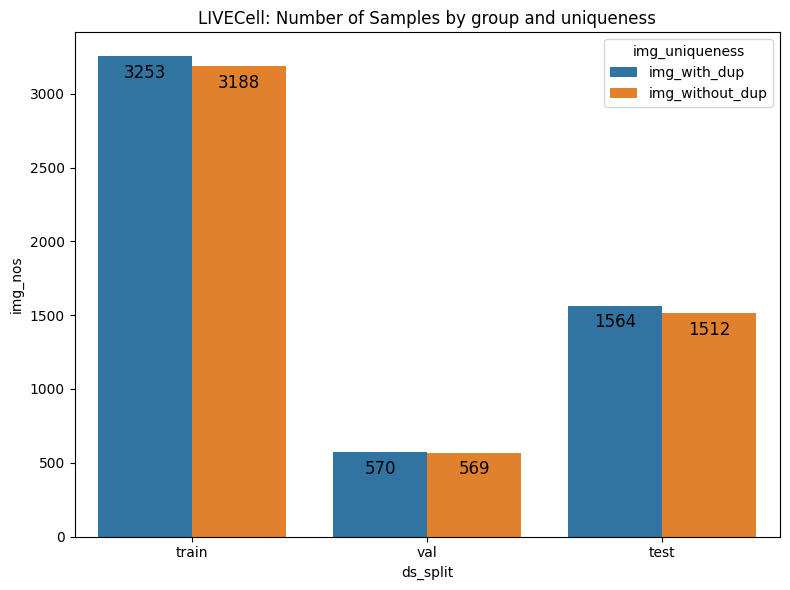

In [25]:
# display the statistics of LIVECell dataset splitting by group and uniqueness

display_statistics_of_ds(len_img_ids_tuple, len_img_filenames_tuple, save=project_dir)

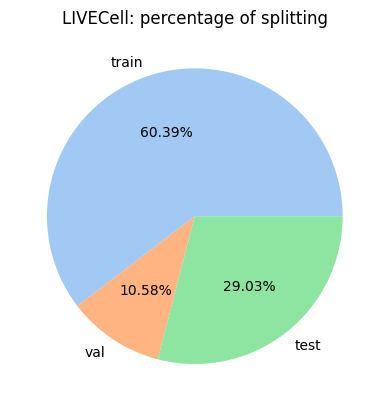

In [26]:
# display the statistics of LIVECell dataset splitting in pie chart

display_statistics_of_ds_pie(len_img_ids_tuple, save=project_dir)